# Bedienungsanleitung zum Gillespie von Johannes Meyer

Als erstes werden alle benötigten externen Pakete geladen. Danach werden schrittweise die Parameter definiert, die zur Durchführung der einzelnen Methoden vonnöten sind.

In [1]:
%matplotlib inline

from context import *
from pandas import DataFrame
import Gillespie as Glp
import matplotlib.pyplot as plt
import numpy as np

## Monte-Carlo-Simulation

Bei der Monte-Carlo-Simulation (MCS) werden mehrere Läufe des Gillespie-Algorithmus mit der gleichen Belegung der Eingabeparameter durchgeführt, um eine Aussage darüber treffen zu können wie sich das **stochastisch** simulierte System im Allgemeinen verhält.

Für einen Gillespie-Lauf werden die stöchiometrischen Matrizen *L* (alle linken Seiten der Reaktionsgleichungen) und *N* (Gesamtumsatz der Reaktionsgleichungen), die stochastischen Ratenkonstanten *rateConstants* für die einzelnen Reaktionen, die Anfangsanzahlen der einzelnen Analyten *startQuantities* und eine Abbruchbedingung in Form einer maximalen Zeit *time_max* **oder** einer maximalen Reaktionenzahl *reaction_limit* benötigt.
Bei der Vergabe der Namen ist darauf zu achten, dass die strings in DataFrames und rateConstants (Reaktionsnamen), sowie in DataFrames und startQuantities (Namen der Molekülspezies) miteinander übereinstimmen.

Für die MCS muss dann noch die Anzahl der auszuführenden Gillespie-Läufe mit *runs* festgelegt werden.

In [2]:
# initialise constants
L = DataFrame({"reaction1":[1, 1, 0, 0, 0],
            "reaction2":[0, 1, 1, 0, 0],
            "reaction3":[0, 0, 0, 1, 0],
            "reaction4":[0, 0, 0, 0, 1]}, index = ["target","probe","interferer","tp-complex","ip-complex"])
R = DataFrame({"reaction1":[0, 0, 0, 1, 0],
            "reaction2":[0, 0, 0, 0, 1],
            "reaction3":[1, 1, 0, 0, 0],
            "reaction4":[0, 1, 1, 0, 0]}, index = ["target","probe","interferer","tp-complex","ip-complex"])
N = R - L

rateConstants = {"reaction1": 0.08, "reaction2": 0.08, "reaction3": 0.08, "reaction4": 0.08}
startQuantities = {"target": [50], "probe": [50], "interferer": [50], "tp-complex": [50], "ip-complex": [50]}
time_maximum = 1.0

runs = 100

In [3]:
gillespies = Glp.monte_carlo_gillespie(rateConstants, L, N, startQuantities, runs=runs, time_max=time_maximum)

## Plotten

Um die Gillespie-berechnungen einzelnd zu plotten kann man aus der Klasse Gillespie die Methode *plot()* ausfrufen. Gegebenfalls kann dies auch mit eigener Farbgebung umgesetzt werden, dabei ist aber darauf zu achten, dass die keys des dictionarys den Namen der Molekülspezies (siehe oben) entsprechen.
*colours* ist der einzige zu übergebende Paramter.

In [4]:
colours = {"target":"red", "probe":"cornflowerblue", "interferer":"goldenrod", "tp-complex":"purple", "ip-complex":"forestgreen"}

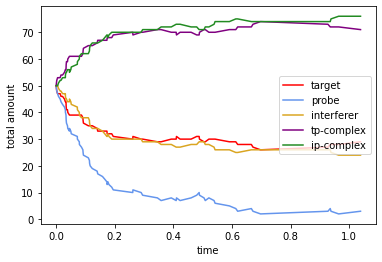

<Figure size 432x288 with 0 Axes>

In [5]:
gillespies[0].plot(colours=colours)

Mit der Methode *multiplot()* kann man dann mehrere Einzelläufe nebeneinander darstellen lassen, um diese besser miteinander vergleichen zu können. Hier funktioniert aber die Legende nicht für alle Anzahlen an Gillespie-Läufen, die als Input übergegeben werden.
Sie wird für 2, 4 und alle größeren durch 3 teilbaren Laufanzahlen korrekt angezeigt. Beim rest erscheint ein **No handles with labels found to put in legend.**-Fehler, die plots werden trotzdem dargestellt.
Benötigter Parameter ist lediglich eine Liste mit den Gillespie-Läufen *gillespies*. Alle weiteren Parameter sind optional. Dabei gibt *x_size* die Höhe des Plot-Arrays an, *y_size* die Breite, *colours* funktioniert wie oben und *outputfile* gibt den Pfad zum Speicherort an, default ist './temp_multiplot.png'.

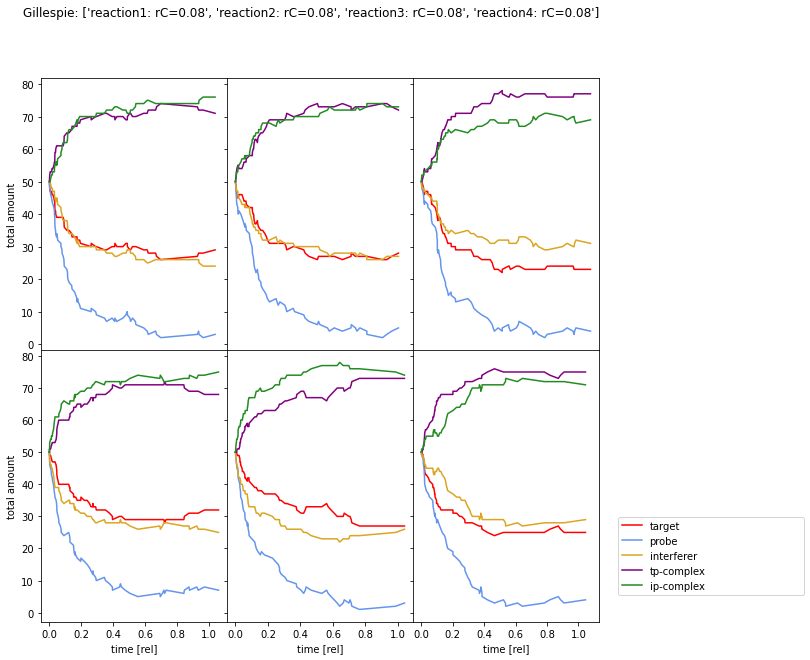

In [6]:
Glp.multiplot(gillespies[:6], colours=colours)

Dann gibt es noch die Funktion *analyte_plot()*, bei der man dann die Einzelnen Analyten aus allen übergebenen Läufen zusammen plotten kann. Die Eingabeparameter sind die gleichen wie bei der *multiplot()* (siehe oben) und auch die Probleme mit der Legende sind hier die gleichen.

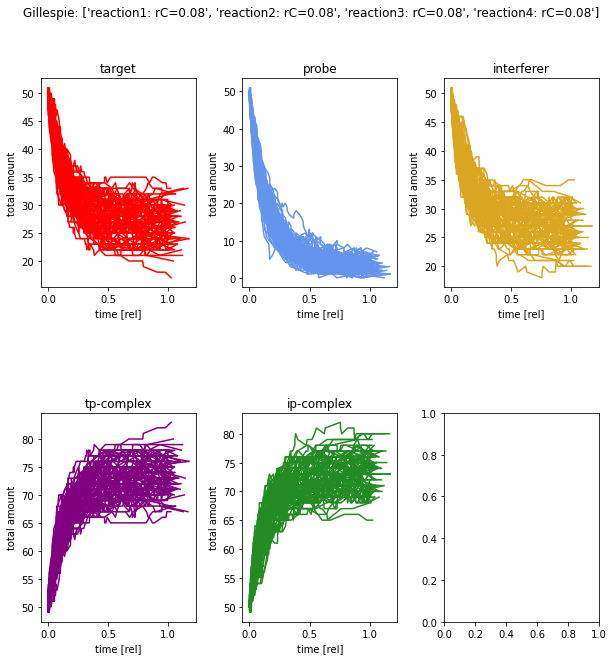

In [7]:
Glp.analyte_plot(gillespies, colours=colours)

Das Gesamtoutputsignal kann mit *make_output_signal()* berechnet werden. Dabei wird eine Liste *gillespies* all jener Gillespie-Objekte übergeben, für die jeweils das Gesamtsignal berechnet werden soll. Welche Molekülspezies bei dieser Berechnung berücksichtigt werden sollen, soll in der Liste *output_species_names* genauer definiert werden.

Das Outputsignal kann dann für den jeweiligen Gillespie-Lauf gegen dessen Zeitwerte geplottet werden.
### Achtung!
Wenn die die falschen Datenreihen gegeneinander geplottet werden, sind diese mit hoher Wahrscheinlichkeit nicht mehr gleich lang und pyplot wirft einen Fehler.

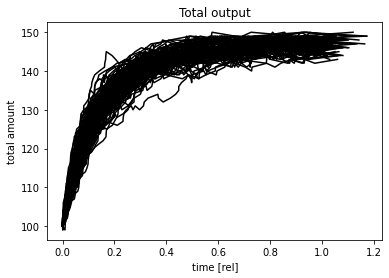

In [8]:
output_signal = Glp.make_output_signal(gillespies, ['tp-complex', 'ip-complex'])

plt.title("Total output")
plt.xlabel("time [rel]")
plt.ylabel("total amount")
for i, run in enumerate(gillespies):
    plt.plot(run.times, output_signal[i], 'black', label='output')

## Statistische Analyse

Um nun eine statistische Analyse der Werte zu erstellen, ist es sinnvoll das System erst im Gleichgewichtszustand (steady state) zu betrachten. Ab welchem Zeitpunkt dies der Fall ist, kann man mit der Methode *get_trimming_time()* berechnen. Dabei kann der Nutzer noch beeinflussen, was er unter "eingeschwungen" oder "im Gleichgewicht versteht".
Es wird eine Liste von Gillespie-Läufen *gillespies* übergeben, damit sichergestellt werden kann, dass das ganze System im steady state ist. Mit *window_length, step_width, vct* können dann die Bedingungen für die fensterweise erfolgende Varianzuntersuchen eingestellt werden.

Mit *window_length* wird die die Größe des sich bewegenden Fensters festgelegt. Sie sollte klein genug sein, um mehrmals in die Datenreihe(n) zu passen. Die *step_width* gibt dann an um wie viele Positionen das Fenster in den Daten verschoben wird, um die nächste Varianz zu berechnen. Und *vct* ist die Abkürzung für variance change threshold und gibt die Abbruchbedingung an, wie sehr sich die Varianz von einem Fenster auf das andere ändern darf.
Ist *window_length* < *step_width*, dann werden Daten übersprungen und man guckt sich die Varianzen nur stichprobenartig an.

Am Ende wird der Zeitpunkt nach dem das System eingeschwungen ist zurück gegeben.
### Achtung!
Auch wenn die Abbruchbedingung am Ende nicht erreicht wird, wird der Anfangszeitpunkt vom zuletzt betrachteten Fenster zurückgegeben.

In [9]:
cut_off = Glp.get_trimming_time(gillespies, window_length=7, step_width=1, vct=0.1)
print(cut_off)

0.031856796086084424


In [10]:
# Tupel von allen Reihen, die zum Rauschen beitragen
## Glp.make_output_signal()
# Mittelwerte aus den Tupeln berechnen
## Glp.make_time_quantity_tuples()
# SNR aus den Mittelwerten berechnen
## snr = Glp.calc_SNR(Glp.calc_mean_quantity([tupl[1] for tupl in tuples if tupl[0] > cut_off]), Glp.calc_mean_quantity())

TypeError: make_output_signal() missing 2 required positional arguments: 'list_gillespies' and 'output_species_names'